<h1><center><font size="25">ForecasterAutoregMultiOutput EXPERIMENTAL</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>February, 2020</i></center>

In [1]:
# !pip uninstall -y skforecast
# !pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
#from skforecast.experimental.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.experimental.model_selection import grid_search_forecaster
from skforecast.experimental.model_selection import time_series_spliter
from skforecast.experimental.model_selection import cv_forecaster
from skforecast.experimental.model_selection import backtesting_forecaster
from skforecast.experimental.model_selection import backtesting_forecaster_intervals

In [3]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from skforecast.ForecasterAutoreg import ForecasterAutoreg
# from skforecast.model_selection import grid_search_forecaster
# from skforecast.model_selection import time_series_spliter
# from skforecast.model_selection import cv_forecaster

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom

## ForecasterAutoregMultiOutput

In [5]:
################################################################################
#                               skforecast                                     #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

import typing
from typing import Union, Dict, List, Tuple
import warnings
import logging
import numpy as np
import pandas as pd
import sklearn
import tqdm

from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


################################################################################
#                         ForecasterAutoregMultiOutput                         #
################################################################################

class ForecasterAutoregMultiOutput():
    '''
    This class turns a scikit-learn regressor into a autoregressive multi-output
    forecaster. A separate model is created for each forecast time step. See Notes
    for more details.
    
    Parameters
    ----------
    regressor : scikit-learn regressor
        An instance of a scikit-learn regressor.
        
    lags : int, list, 1D np.array, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags` (included).
            `list` or `np.array`: include only lags present in `lags`.
            
    steps : int
        Number of future steps the forecaster will predict when using method
        `predict()`. Since a diferent model is created for each step, this value
        should be defined before training.
    
    Attributes
    ----------
    regressor : scikit-learn regressor
        An instance of a scikit-learn regressor. One instance of this regressor
        is trainned for each step. All them are stored in `slef.regressors_`.
        
    regressors_ : dict
        Dictionary with scikit-learn regressors trained for each step.
        
    steps : int
        Number of future steps the forecaster will predict when using method
        `predict()`. Since a diferent model is created for each step, this value
        should be defined before training.
        
    lags : 1D np.array
        Lags used as predictors.
        
    max_lag : int
        Maximum value of lag included in lags.
        
    last_window : 1D np.ndarray
        Last time window the forecaster has seen when trained. It stores the
        values needed to calculate the lags used to predict the next `step`
        after the training data.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type used for the exogenous variable/s.
            
    exog_shape : tuple
        Shape of exog used in training.
        
        
    Notes
    -----
    A separate model is created for each forecast time step. It is important to
    note that all models share the same configuration of parameters and
    hiperparameters.
     
    '''
    
    def __init__(self, regressor, steps: int,
                 lags: Union[int, np.ndarray, list]) -> None:
        
        self.regressor     = regressor
        self.steps         = steps
        self.regressors_   = {step: clone(self.regressor) for step in range(steps)}
        self.last_window   = None
        self.included_exog = False
        self.exog_type     = False
        self.exog_shape    = None

        
        if not isinstance(steps, int) or steps < 1:
            raise Exception(
                f"`steps` must be integer greater than 0. Got {steps}."
            )
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
                
        
    def __repr__(self) -> str:
        '''
        Information displayed when a ForecasterAutoreg object is printed.
        '''

        info =    "============================" \
                + "ForecasterAutoregMultiOutput" \
                + "============================" \
                + "\n" \
                + "Regressor: " + str(self.regressor) \
                + "\n" \
                + "Steps: " + str(self.steps) \
                + "\n" \
                + "Lags: " + str(self.lags) \
                + "\n" \
                + "Exogenous variable: " + str(self.included_exog) \
                + "\n" \
                + "Parameters: " + str(self.regressor.get_params())

        return info
    

    
    def create_lags(self, y: Union[np.ndarray, pd.Series]) -> Tuple[np.ndarray, np.ndarray]:
        '''
        Transforms a time series into two 2D arrays of pairs predictor-response.
        
        Notice that the returned matrix X_data, contains the lag 1 in the
        first column, the lag 2 in the second column and so on.
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.

        Returns 
        -------
        X_data : 2D np.ndarray
            2D array with the lag values (predictors).
        
        y_data : 2D np.ndarray
            Values of the time series related to each row of `X_data`.
            
        '''
        
        self._check_y(y=y)
        y = self._preproces_y(y=y)        
        
        if self.max_lag > len(y):
            raise Exception(
                f"Maximum lag can't be higer than `y` length. "
                f"Got maximum lag={self.max_lag} and `y` length={len(y)}."
            )
            
        n_splits = len(y) - self.max_lag - (self.steps -1)
        X_data  = np.full(shape=(n_splits, self.max_lag), fill_value=np.nan, dtype=float)
        y_data  = np.full(shape=(n_splits, self.steps), fill_value=np.nan, dtype= float)

        for i in range(n_splits):
            X_index = np.arange(i, self.max_lag + i)
            y_index = np.arange(self.max_lag + i, self.max_lag + i + self.steps)

            X_data[i, :] = y[X_index]
            y_data[i, :] = y[y_index]
            
        X_data = X_data[:, -self.lags]
                    
        return X_data, y_data


    def create_train_X_y(self, y: Union[np.ndarray, pd.Series],
                         exog: Union[np.ndarray, pd.Series]=None) -> Tuple[np.array, np.array]:
        '''
        Create training matrices X, y. The created matrices contain the target
        variable and predictors needed to train all the forecaster (one per step).         
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].


        Returns 
        -------
        X_train : 2D np.ndarray, shape (len(y) - self.max_lag, len(self.lags) + exog.shape[1]*steps)
            2D array with the training values (predictors).
            
        y_train : 1D np.ndarray, shape (len(y) - self.max_lag)
            Values (target) of the time series related to each row of `X_train`.
        
        '''

        self._check_y(y=y)
        y = self._preproces_y(y=y)

        if exog is not None:
            self._check_exog(exog=exog)
            self.exog_type = type(exog)
            exog = self._preproces_exog(exog=exog)
            self.included_exog = True
            self.exog_shape = exog.shape

            if exog.shape[0] != len(y):
                raise Exception(
                    f"`exog` must have same number of samples as `y`"
                )

                   
        X_lags, y_train = self.create_lags(y=y)

        if exog is None:
            X_train = X_lags
        else:
            # Trasform exog to match multi output format
            X_exog = self._exog_to_multi_output(exog=exog)

            # The first `self.max_lag` positions have to be removed from X_exog
            # since they are not in X_lags.
            X_exog = X_exog[-X_lags.shape[0]:, ]

            X_train = np.column_stack((X_lags, X_exog))

        return X_train, y_train

    
    def filter_train_X_y_for_step(self, step: int,
                              X_train: np.ndarray,
                              y_train: np.ndarray) -> Tuple[np.array, np.array]:

        '''
        Select columns needed to train a forcaster for a specific step. The imput matrices
        should be created with created with `create_train_X_y()`.         

        Parameters
        ----------
        step : int
            step for which columns must be selected selected. Starts at 0.

        X_train : 2D np.ndarray
            2D array with the training values (predictors).
            
        y_train : 1D np.ndarray
            Values (target) of the time series related to each row of `X_train`.


        Returns 
        -------
        X_train_step : 2D np.ndarray
            2D array with the training values (predictors) for step.
            
        y_train_step : 1D np.ndarray, shape (len(y) - self.max_lag)
            Values (target) of the time series related to each row of `X_train`.

        '''

        if step > self.steps - 1:
            raise Exception(
                f"Invalid value `step`. For this forecaster, the maximum step is {self.steps-1}."
            )

        y_train_step = y_train[:, step]

        if not self.included_exog:
            X_train_step = X_train
        else:
            idx_columns_lags = np.arange(0, self.max_lag)
            idx_columns_exog = np.arange(X_train.shape[1])[self.max_lag + step::self.steps]
            idx_columns = np.hstack((idx_columns_lags, idx_columns_exog))
            X_train_step = X_train[:, idx_columns]

        return  X_train_step, y_train_step
    
    
    def fit(self, y: Union[np.ndarray, pd.Series],
            exog: Union[np.ndarray, pd.Series]=None) -> None:
        '''
        Training ForecasterAutoregMultiOutput

        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.

        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].


        Returns 
        -------
        self : ForecasterAutoregMultiOutput
            Trained ForecasterAutoregMultiOutput

        '''

        # Reset values in case the forecaster has already been fitted before.
        self.included_exog = False
        self.exog_type     = None
        self.exog_shape    = None

        self._check_y(y=y)
        y = self._preproces_y(y=y)

        if exog is not None:
            self._check_exog(exog=exog)
            self.exog_type = type(exog)
            exog = self._preproces_exog(exog=exog)
            self.included_exog = True
            self.exog_shape = exog.shape

            if exog.shape[0] != len(y):
                raise Exception(
                    f"`exog` must have same number of samples as `y`"
                )

        X_train, y_train = self.create_train_X_y(y=y, exog=exog)

        # Train one regressor for each step 
        for step in range(self.steps):

            X_train_step, y_train_step = self.filter_train_X_y_for_step(
                                            step    = step,
                                            X_train = X_train,
                                            y_train = y_train
                                         ) 
            self.regressors_[step].fit(X_train_step, y_train_step)

        # The last time window of training data is stored so that lags needed as
        # predictors in the first iteration of `predict()` can be calculated.
        if self.steps >= self.max_lag:
            self.last_window = y_train[-1, -self.max_lag:]
        else:
            self.last_window = np.hstack((
                                    y_train[-(self.max_lag-self.steps + 1):-1, 0],
                                    y_train[-1, :]
                               ))

    
    def predict(self, last_window: Union[np.ndarray, pd.Series]=None,
                exog: np.ndarray=None, steps=None):
        '''
        Multi-step prediction. The number of future steps predicted is defined when
        ininitializing the forecaster.

        Parameters
        ----------

        last_window : 1D np.ndarray, pd.Series, shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of predictiont (t + 1).

            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.

        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s.

        steps : Ignored
            Not used, present here for API consistency by convention.

        Returns 
        -------
        predictions : 1D np.array, shape (steps,)
            Values predicted.

        '''

        if exog is None and self.included_exog:
            raise Exception(
                f"Forecaster trained with exogenous variable/s. "
                f"Same variable/s must be provided in `predict()`."
            )

        if exog is not None and not self.included_exog:
            raise Exception(
                f"Forecaster trained without exogenous variable/s. "
                f"`exog` must be `None` in `predict()`."
            )

        if exog is not None:
            self._check_exog(
                exog=exog, ref_type = self.exog_type, ref_shape=self.exog_shape
            )
            exog = self._preproces_exog(exog=exog)
            if exog.shape[0] < self.steps:
                raise Exception(
                    f"`exog` must have at least as many values as `steps` predicted."
                )

            exog = self._exog_to_multi_output(exog=exog)

        if last_window is not None:
            self._check_last_window(last_window=last_window)
            last_window = self._preproces_last_window(last_window=last_window)
            if last_window.shape[0] < self.max_lag:
                raise Exception(
                    f"`last_window` must have as many values as as needed to "
                    f"calculate the maximum lag ({self.max_lag})."
                )
        else:
            last_window = self.last_window.copy()


        predictions = np.full(shape=self.steps, fill_value=np.nan)
        X_lags = last_window[-self.lags].reshape(1, -1)

        for step in range(self.steps):
            regressor = self.regressors_[step]
            if exog is None:
                X = X_lags
                predictions[step] = regressor.predict(X)
            else:
                # Only columns from exog related with the current step are selected.
                X = np.hstack([X_lags, exog[0][step::self.steps].reshape(1, -1)])
                predictions[step] = regressor.predict(X)

        return predictions.reshape(-1)
        
    
    
    def _check_y(self, y: Union[np.ndarray, pd.Series]) -> None:
        '''
        Raise Exception if `y` is not 1D `np.ndarray` or `pd.Series`.
        
        Parameters
        ----------        
        y : np.ndarray, pd.Series
            Time series values

        '''
        
        if not isinstance(y, (np.ndarray, pd.Series)):
            raise Exception('`y` must be `1D np.ndarray` or `pd.Series`.')
        elif isinstance(y, np.ndarray) and y.ndim != 1:
            raise Exception(
                f"`y` must be `1D np.ndarray` o `pd.Series`, "
                f"got `np.ndarray` with {y.ndim} dimensions."
            )
            
        return
    
    
    def _check_last_window(self, last_window: Union[np.ndarray, pd.Series]) -> None:
        '''
        Raise Exception if `last_window` is not 1D `np.ndarray` or `pd.Series`.
        
        Parameters
        ----------        
        last_window : np.ndarray, pd.Series
            Time series values

        '''
        
        if not isinstance(last_window, (np.ndarray, pd.Series)):
            raise Exception('`last_window` must be `1D np.ndarray` or `pd.Series`.')
        elif isinstance(last_window, np.ndarray) and last_window.ndim != 1:
            raise Exception(
                f"`last_window` must be `1D np.ndarray` o `pd.Series`, "
                f"got `np.ndarray` with {last_window.ndim} dimensions."
            )
            
        return
        
        
    def _check_exog(self, exog: Union[np.ndarray, pd.Series], 
                    ref_type: type=None, ref_shape: tuple=None) -> None:
        '''
        Raise Exception if `exog` is not `np.ndarray` or `pd.Series`.
        If `ref_shape` is provided, raise Exception if `ref_shape[1]` do not match
        `exog.shape[1]` (number of columns).
        
        Parameters
        ----------        
        exog : np.ndarray, pd.Series
            Time series values

        '''
            
        if not isinstance(exog, (np.ndarray, pd.Series)):
            raise Exception('`exog` must be `np.ndarray` or `pd.Series`.')
            
        if isinstance(exog, np.ndarray) and exog.ndim > 2:
            raise Exception(
                    f" If `exog` is `np.ndarray`, maximum allowed dim=2. "
                    f"Got {exog.ndim}."
                )
            
        if ref_type is not None:
            
            if ref_type == pd.Series:
                if isinstance(exog, pd.Series):
                    return
                elif isinstance(exog, np.ndarray) and exog.ndim == 1:
                    return
                elif isinstance(exog, np.ndarray) and exog.shape[1] == 1:
                    return
                else:
                    raise Exception(
                        f"`exog` must be: `pd.Series`, `np.ndarray` with 1 dimension"
                        f"or `np.ndarray` with 1 column in the second dimension. "
                        f"Got `np.ndarray` with {exog.shape[1]} columns."
                    )
                    
            if ref_type == np.ndarray:
                if exog.ndim == 1 and ref_shape[1] == 1:
                    return
                elif exog.ndim == 1 and ref_shape[1] > 1:
                    raise Exception(
                        f"`exog` must have {ref_shape[1]} columns. "
                        f"Got `np.ndarray` with 1 dimension or `pd.Series`."
                    )
                elif ref_shape[1] != exog.shape[1]:
                    raise Exception(
                        f"`exog` must have {ref_shape[1]} columns. "
                        f"Got `np.ndarray` with {exog.shape[1]} columns."
                    )     
        return
    
        
    def _preproces_y(self, y) -> np.ndarray:
        
        '''
        Transforms `y` to 1D `np.ndarray` if it is `pd.Series`.
        
        Parameters
        ----------        
        y :1D np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        y: 1D np.ndarray, shape(samples,)
        '''
        
        if isinstance(y, pd.Series):
            return y.to_numpy().copy()
        else:
            return y.copy()
        
    def _preproces_last_window(self, last_window) -> np.ndarray:
        
        '''
        Transforms `last_window` to 1D `np.ndarray` if it is `pd.Series`.
        
        Parameters
        ----------        
        last_window :1D np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        last_window: 1D np.ndarray, shape(samples,)
        '''
        
        if isinstance(last_window, pd.Series):
            return last_window.to_numpy().copy()
        else:
            return last_window.copy()
        
        
    def _preproces_exog(self, exog) -> np.ndarray:
        
        '''
        Transforms `exog` to `np.ndarray` if it is `pd.Series`.
        If 1D `np.ndarray` reshape it to (n_samples, 1)
        
        Parameters
        ----------        
        exog : np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        exog: np.ndarray, shape(samples,)
        '''
        
        if isinstance(exog, pd.Series):
            exog_prep = exog.to_numpy().reshape(-1, 1).copy()
        elif isinstance(exog, np.ndarray) and exog.ndim == 1:
            exog_prep = exog.reshape(-1, 1).copy()
        else:
            exog_prep = exog.copy()
            
        return exog_prep
    

    def _exog_to_multi_output(self, exog)-> np.ndarray:
        
        '''
        Transforms `exog` to `np.ndarray` with the shape needed for multioutput
        regresors.
        
        Parameters
        ----------        
        exog : np.ndarray, shape(samples,)
            Time series values

        Returns 
        -------
        exog_transformed: np.ndarray, shape(samples - self.max_lag, self.steps)
        '''

        exog_transformed = []

        for column in range(exog.shape[1]):

            exog_column_transformed = []

            for i in range(exog.shape[0] - (self.steps -1)):
                exog_column_transformed.append(exog[i:i + self.steps, column])

            if len(exog_column_transformed) > 1:
                exog_column_transformed = np.vstack(exog_column_transformed)

            exog_transformed.append(exog_column_transformed)

        if len(exog_transformed) > 1:
            exog_transformed = np.hstack(exog_transformed)
        else:
            exog_transformed = exog_column_transformed

        return exog_transformed
    
    
    def set_params(self, **params: dict) -> None:
        '''
        Set new values to the parameters of the scikit learn model stored in the
        forecaster. It is important to note that all models share the same 
        configuration of parameters and hiperparameters.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        '''
        
        self.regressor.set_params(**params)
        self.regressors_ = {step: clone(self.regressor) for step in range(self.steps)}
        
        
        
    def set_lags(self, lags: int) -> None:
        '''      
        Set new value to the attribute `lags`.
        Attribute `max_lag` is also updated.
        
        Parameters
        ----------
        lags : int, list, 1D np.array, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags`.
            `list` or `np.array`: include only lags present in `lags`.

        Returns 
        -------
        self
        
        '''
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        

    def get_coef(self, step) -> np.ndarray:
        '''      
        Return estimated coefficients for the linear regression model stored in
        the forecaster for a specific step. Since a separate model is created for
        each forecast time step, it is necessary to select the model from which
        retireve information.
        
        Only valid when the forecaster has been trained using as `regressor:
        `LinearRegression()`, `Lasso()` or `Ridge()`.
        
        Parameters
        ----------
        step : int
            Model from which retireve information (a separate model is created for
            each forecast time step).

        Returns 
        -------
        coef : 1D np.ndarray
            Value of the coefficients associated with each predictor (lag).
            Coefficients are aligned so that `coef[i]` is the value associated
            with `self.lags[i]`.
        
        '''
        
        if step > self.steps:
            raise Exception(
                f"Forecaster traied for {self.steps} steps. Got step={step}."
            )
            
        
        valid_instances = (sklearn.linear_model._base.LinearRegression,
                           sklearn.linear_model._coordinate_descent.Lasso,
                           sklearn.linear_model._ridge.Ridge
                           )
        
        if not isinstance(self.regressor, valid_instances):
            warnings.warn(
                ('Only forecasters with `regressor` `LinearRegression()`, ' +
                 ' `Lasso()` or `Ridge()` have coef.')
            )
            return
        else:
            coef = self.regressors_[step-1].coef_
            
        return coef

    
    def get_feature_importances(self, step) -> np.ndarray:
        '''      
        Return impurity-based feature importances of the model stored in
        the forecaster for a specific step. Since a separate model is created for
        each forecast time step, it is necessary to select the model from which
        retireve information.
        
        Only valid when the forecaster has been trained using
        `regressor=GradientBoostingRegressor()` or `regressor=RandomForestRegressor`.

        Parameters
        ----------
        step : int
            Model from which retireve information (a separate model is created for
            each forecast time step).

        Returns 
        -------
        feature_importances : 1D np.ndarray
        Impurity-based feature importances associated with each predictor (lag).
        Values are aligned so that `feature_importances[i]` is the value
        associated with `self.lags[i]`.
        '''
        
        if step > self.steps:
            raise Exception(
                f"Forecaster traied for {self.steps} steps. Got step={step}."
            )
        
        valid_instances = (sklearn.ensemble._forest.RandomForestRegressor,
                           sklearn.ensemble._gb.GradientBoostingRegressor)

        if not isinstance(self.regressor, valid_instances):
            warnings.warn(
                ('Only forecasters with `regressor=GradientBoostingRegressor()` '
                 'or `regressor=RandomForestRegressor`.')
            )
            return
        else:
            feature_importances = self.regressors_[step-1].feature_importances_

        return feature_importances

In [6]:
################################################################################
#                        skforecast.model_selection                            #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8


import typing
from typing import Union, Dict
import numpy as np
import pandas as pd
import logging
import tqdm
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

# from .ForecasterAutoreg import ForecasterAutoreg
# from .ForecasterCustom import ForecasterCustom
# from .ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


def time_series_spliter(y: Union[np.ndarray, pd.Series],
                        initial_train_size: int, steps: int,
                        allow_incomplete_fold: bool=True,
                        verbose: bool=True):
    '''
    
    Split indices of a time series into multiple train-test pairs. The order of
    is maintained and the training set increases in each iteration.
    
    Parameters
    ----------        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    verbose : bool, default `True`
        Print number of splits created.

    Yields
    ------
    train : 1D np.ndarray
        Training indices.
        
    test : 1D np.ndarray
        Test indices.
        
    '''
    
    if not isinstance(y, (np.ndarray, pd.Series)):

        raise Exception('`y` must be `1D np.ndarray` o `pd.Series`.')

    elif isinstance(y, np.ndarray) and y.ndim != 1:

        raise Exception(
            f"`y` must be `1D np.ndarray` o `pd.Series`, "
            f"got `np.ndarray` with {y.ndim} dimensions."
        )
        
    if isinstance(y, pd.Series):
        y = y.to_numpy().copy()
    
  
    folds     = (len(y) - initial_train_size) // steps  + 1
    remainder = (len(y) - initial_train_size) % steps   
    
    if verbose:
        if remainder == 0:
            print(f"Number of folds: {folds - 1}")
        if remainder != 0 and allow_incomplete_fold:
            print(f"Number of folds: {folds}")
            print(
                f"Since `allow_incomplete_fold=True`, "
                f"last fold includes {remainder} extra observations."
            )
        elif remainder != 0 and not allow_incomplete_fold:
            print(f"Number of folds: {folds - 1}")
            print(
                f"Since `allow_incomplete_fold=False`, "
                f"last {remainder} observations are descarted."
            )

    
    for i in range(folds):
          
        if i < folds - 1:
            train_end     = initial_train_size + i * steps    
            train_indices = range(train_end)
            test_indices  = range(train_end, train_end + steps)
            
        else:
            if remainder != 0 and allow_incomplete_fold:
                train_end     = initial_train_size + i * steps  
                train_indices = range(train_end)
                test_indices  = range(train_end, train_end + remainder)
            else:
                break
        
        yield train_indices, test_indices
        

def cv_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                  initial_train_size: int, steps: int,
                  metric: str, exog: Union[np.ndarray, pd.Series]=None,
                  allow_incomplete_fold: bool=True, verbose: bool=True):
    '''
    Cross-validation of `ForecasterAutoreg`, `ForecasterCustom` or `ForecasterAutoregMultiOutput`
    object. The order of is maintained and the training set increases in each iteration.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom, ForecasterAutoregMultiOutput
        `ForecasterAutoreg`, `ForecasterCustom` or `ForecasterAutoregMultiOutput` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
            
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    verbose : bool, default `True`
        Print number of folds used for cross validation.

    Returns 
    -------
    cv_results: 1D np.ndarray
        Value of the metric for each partition.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)

    if metric not in ['mean_squared_error', 'mean_absolute_error',
                      'mean_absolute_percentage_error']:
        raise Exception(
            f"Allowed metrics are: 'mean_squared_error', 'mean_absolute_error' and "
            f"'mean_absolute_percentage_error'. Got {metric}."
        )
    
    cv_results = []
    
    metrics = {
        'mean_squared_error': mean_squared_error,
        'mean_absolute_error': mean_absolute_error,
        'mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
    
    splits = time_series_spliter(
                y                     = y,
                initial_train_size    = initial_train_size,
                steps                 = steps,
                allow_incomplete_fold = allow_incomplete_fold,
                verbose               = verbose
             )
    
    for train_index, test_index in splits:
        
        if exog is None:
            forecaster.fit(y=y[train_index])      
            pred = forecaster.predict(steps=len(test_index))
            
        else:
            
            forecaster.fit(y=y[train_index], exog=exog[train_index])      
            pred = forecaster.predict(steps=len(test_index), exog=exog[test_index])
               
        metric_value = metric(
                            y_true = y[test_index],
                            y_pred = pred
                       )
        
        cv_results.append(metric_value)
                          
    return np.array(cv_results)


def backtesting_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                           initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           verbose: bool=False):
    '''
    Backtesting (validation) of `ForecasterAutoreg`, `ForecasterCustom` or
    `ForecasterAutoregMultiOutput` object.
    The model is trained only once using the `initial_train_size` first observations.
    In each iteration, a number of `steps` predictions are evaluated.
    
    This evaluation is much faster than `cv_forecaster()` since the model is
    trained only once.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom, ForecasterAutoregMultiOutput
        `ForecasterAutoreg`, `ForecasterCustom` or `ForecasterAutoregMultiOutput` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
            
    verbose : bool, default `False`
        Print number of folds used for backtesting.

    Returns 
    -------
    backtest_predictions: 1D np.ndarray
        Value of predictions.
        
    metric_value: np.ndarray shape (1,)
        Value of the metric.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)

    if metric not in ['mean_squared_error', 'mean_absolute_error',
                      'mean_absolute_percentage_error']:
        raise Exception(
            f"Allowed metrics are: 'mean_squared_error', 'mean_absolute_error' and "
            f"'mean_absolute_percentage_error'. Got {metric}."
        )
    
    backtest_predictions = []
    
    metrics = {
        'mean_squared_error': mean_squared_error,
        'mean_absolute_error': mean_absolute_error,
        'mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
        
    if exog is None:
        forecaster.fit(y=y[:initial_train_size])      
    else:
        forecaster.fit(y=y[:initial_train_size], exog=exog[:initial_train_size])     
    
    
    folds     = (len(y) - initial_train_size) // steps + 1
    remainder = (len(y) - initial_train_size) % steps
    window_size = len(forecaster.last_window)

    if isinstance(forecaster, ForecasterAutoregMultiOutput) and remainder != 0:
        # In ForecasterAutoregMultiOutput predictions are not iterative,
        # therefore no remainder is allowed.
        logging.warning(
                f"Backtesting `ForecasterAutoregMultiOutput` only allow completed "
                f"folds. Last {remainder} observations are excluded."
        )
        remainder=0
    
    if verbose:
        print(f"Number of observations used for training: {initial_train_size}")
        print(f"Number of observations used for testing: {len(y) - initial_train_size}")
        print(f"    Number of folds: {folds - 1 * (remainder == 0)}")
        print(f"    Number of steps per fold: {steps}")
        if remainder != 0:
            print(f"    Last fold only includes {remainder} observations")
      
    for i in range(folds):
        last_window_end   = initial_train_size + i * steps
        last_window_start = (initial_train_size + i * steps) - window_size 
        last_window       = y[last_window_start:last_window_end]
                
        if i < folds - 1:
            if exog is None:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window
                        )
            else:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps]
                        )
        elif remainder != 0:
            steps = remainder 
            if exog is None:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window
                        )
            else:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps]
                        )
        else:
            continue
        
        backtest_predictions.append(pred)
    
    backtest_predictions = np.concatenate(backtest_predictions)
    metric_value = metric(
                        y_true = y[initial_train_size: initial_train_size + len(backtest_predictions)],
                        y_pred = backtest_predictions
                   )

    return np.array([metric_value]), backtest_predictions



def grid_search_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                           param_grid: dict, initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           lags_grid: list=None, method: str='cv',
                           allow_incomplete_fold: bool=True, return_best: bool=True,
                           verbose: bool=True):
    '''
    Exhaustive search over specified parameter values for a Forecaster object.
    Validation is done using time series cross-validation or backtesting.
    
    Parameters
    ----------
    
    forecaster : ForecasterAutoreg, ForecasterCustom, ForecasterAutoregMultiOutput
        ForecasterAutoreg, ForecasterCustom or ForecasterAutoregMultiOutput object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
        
    param_grid : dict
        Dictionary with parameters names (`str`) as keys and lists of parameter
        settings to try as values.
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
           
    lags_grid : list of int, lists, np.narray or range. 
        Lists of `lags` to try. Only used if forecaster is an instance of 
        `ForecasterCustom`.
        
    method : {'cv', 'backtesting'}
        Method used to estimate the metric for each parameter combination.
        'cv' for time series crosvalidation and 'backtesting' for simple
        backtesting. 'backtesting' is much faster since the model is fitted only
        once.
        
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    return_best : bool
        Refit the `forecaster` using the best found parameters on the whole data.
        
    verbose : bool, default `True`
        Print number of folds used for cv or backtesting.

    Returns 
    -------
    results: pandas.DataFrame
        Metric value estimated for each combination of parameters.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    if isinstance(forecaster, ForecasterCustom):
        if lags_grid is not None:
            logging.warning(
                '`lags_grid` ignored if forecaster is an instance of `ForecasterCustom`.'
            )
        lags_grid = ['custom predictors']
        
    elif lags_grid is None:
        lags_grid = [forecaster.lags]
        
      
    lags_list = []
    params_list = []
    metric_list = []
    
    param_grid =  list(ParameterGrid(param_grid))

    logging.info(
        f"Number of models to fit: {len(param_grid)*len(lags_grid)}"
    )
    
    for lags in tqdm.tqdm(lags_grid, desc='loop lags_grid', position=0):
        
        if isinstance(forecaster, (ForecasterAutoreg, ForecasterAutoregMultiOutput)):
            forecaster.set_lags(lags)
            lags = forecaster.lags.copy()
        
        for params in tqdm.tqdm(param_grid, desc='loop param_grid', position=1, leave=False):

            forecaster.set_params(**params)
            
            if method == 'cv':
                metrics = cv_forecaster(
                                forecaster = forecaster,
                                y          = y,
                                exog       = exog,
                                initial_train_size = initial_train_size,
                                steps  = steps,
                                metric = metric,
                                allow_incomplete_fold = allow_incomplete_fold,
                                verbose = verbose
                             )
            else:
                metrics = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = y,
                                exog       = exog,
                                initial_train_size = initial_train_size,
                                steps  = steps,
                                metric = metric,
                                verbose = verbose
                             )[0]

            lags_list.append(lags)
            params_list.append(params)
            metric_list.append(metrics.mean())
            
    results = pd.DataFrame({
                'lags'  : lags_list,
                'params': params_list,
                'metric': metric_list})
    
    results = results.sort_values(by='metric', ascending=True)
    
    if return_best:
        
        best_lags = results['lags'].iloc[0]
        best_params = results['params'].iloc[0]
        logging.info(
            f"Refitting `forecaster` using the best found parameters and the whole data set: \n"
            f"lags: {best_lags} \n"
            f"params: {best_params}\n"
        )
        
        if isinstance(forecaster, (ForecasterAutoreg, ForecasterAutoregMultiOutput)):
            forecaster.set_lags(best_lags)
            
        forecaster.set_params(**best_params)
        forecaster.fit(y=y, exog=exog)
            
    return results


def backtesting_forecaster_intervals(forecaster, y: Union[np.ndarray, pd.Series],
                           initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           interval: list=[5, 95], n_boot: int=500,
                           in_sample_residuals: bool=True, verbose: bool=False):
    '''
    Backtesting (validation) of `ForecasterAutoreg` or `ForecasterCustom` object.
    The model is trained only once using the `initial_train_size` first observations.
    In each iteration, a number of `steps` predictions are evaluated. Both, 
    predictions and intervals, are calculated.
    
    This evaluation is much faster than `cv_forecaster()` since the model is
    trained only once.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom
        `ForecasterAutoreg` or `ForecasterCustom` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
        
    interval: list, default `[5, 100]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
    n_boot: int, default `500`
        Number of bootstrapping iterations used to estimate prediction
        intervals.

    in_sample_residuals: bool, default `True`
        If `True`, residuals from the training data are used as proxy of
        prediction error to create prediction intervals.
        
    verbose : bool, default `True`
        Print number of folds used for backtesting.

    Returns 
    -------
    backtest_predictions: np.ndarray
        If `include_intervals=True`, 2D np.ndarray shape(steps, 3) with predicted
        value and their estimated interval.
            Column 0 = predictions
            Column 1 = lower bound interval
            Column 2 = upper bound interval
        
    metric_value: np.ndarray shape (1,)
        Value of the metric.

    Notes
    -----
    More information about prediction intervals in forecasting:
    https://otexts.com/fpp2/prediction-intervals.html
    Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
    George Athanasopoulos.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)

    if metric not in ['mean_squared_error', 'mean_absolute_error',
                      'mean_absolute_percentage_error']:
        raise Exception(
            f"Allowed metrics are: 'mean_squared_error', 'mean_absolute_error' and "
            f"'mean_absolute_percentage_error'. Got {metric}."
        )
    
    backtest_predictions = []
    
    metrics = {
        'mean_squared_error': mean_squared_error,
        'mean_absolute_error': mean_absolute_error,
        'mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
        
    if exog is None:
        forecaster.fit(y=y[:initial_train_size])   
    else:
        forecaster.fit(y=y[:initial_train_size], exog=exog[:initial_train_size])     
    
    
    folds     = (len(y) - initial_train_size) // steps + 1
    remainder = (len(y) - initial_train_size) % steps
    window_size = len(forecaster.last_window)
    
    if verbose:
        print(f"Number of observations used for training: {initial_train_size}")
        print(f"Number of observations used for testing: {len(y) - initial_train_size}")
        print(f"    Number of folds: {folds - 1 * (remainder == 0)}")
        print(f"    Number of steps per fold: {steps}")
        if remainder != 0:
            print(f"    Last fold only includes {remainder} observations")
    
    for i in range(folds):
        
        last_window_end   = initial_train_size + i * steps
        last_window_start = (initial_train_size + i * steps) - window_size 
        last_window       = y[last_window_start:last_window_end]
                
        if i < folds - 1:
            if exog is None:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
            else:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps],
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
        elif remainder != 0:
            steps = remainder 
            if exog is None:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
            else:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps],
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
        else:
            continue
        
        backtest_predictions.append(pred)
    
    backtest_predictions = np.concatenate(backtest_predictions)
    metric_value = metric(
                        y_true = y[initial_train_size:],
                        y_pred = backtest_predictions[:, 0]
                   )

    return np.array([metric_value]), backtest_predictions

import string
endog = np.arange(10) + 1
exog  = np.column_stack((
            np.array(list(string.ascii_lowercase))[:10],
            np.array(list(string.ascii_uppercase))[:10]
        ))

forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 2,
                    lags      = 3
                )

X_lags, y = forecaster.create_lags(endog)
print(X_lags)
print(y)

exog_prep = forecaster._preproces_exog(exog)
exog_prep = forecaster._exog_to_multi_output(exog_prep)
print(np.column_stack((X_lags, exog_prep[-X_lags.shape[0]:])))

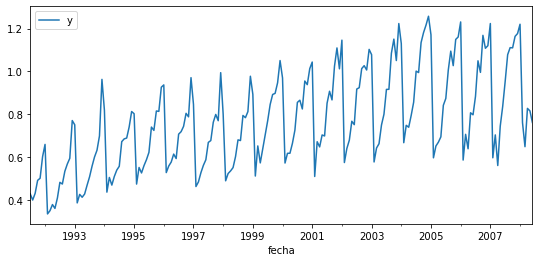

In [20]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [21]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(datos_train)

In [19]:
def create_train_X_y(self, y: Union[np.ndarray, pd.Series],
                     exog: Union[np.ndarray, pd.Series]=None) -> Tuple[np.array, np.array]:
        '''
        Create training matrices X, y. The created matrices contain the target
        variable and predictors needed to train all the forecaster (one per step).         
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].


        Returns 
        -------
        X_train : 2D np.ndarray, shape (len(y) - self.max_lag, len(self.lags) + exog.shape[1]*steps)
            2D array with the training values (predictors).
            
        y_train : 1D np.ndarray, shape (len(y) - self.max_lag)
            Values (target) of the time series related to each row of `X_train`.
        
        '''

        self._check_y(y=y)
        y = self._preproces_y(y=y)

        if exog is not None:
            self._check_exog(exog=exog)
            self.exog_type = type(exog)
            exog = self._preproces_exog(exog=exog)
            self.included_exog = True
            self.exog_shape = exog.shape

            if exog.shape[0] != len(y):
                raise Exception(
                    f"`exog` must have same number of samples as `y`"
                )

                   
        X_lags, y_train = self.create_lags(y=y)

        if exog is None:
            X_train = X_lags
        else:
            # Trasform exog to match multi output format
            X_exog = self._exog_to_multi_output(exog=exog)

            # The first `self.max_lag` positions have to be removed from X_exog
            # since they are not in X_lags.
            X_exog = X_exog[-X_lags.shape[0]:, ]

            X_train = np.column_stack((X_lags, X_exog))

        return X_train, y_train


def filter_train_X_y_for_step(self, step: int,
                              X_train: np.ndarray,
                              y_train: np.ndarray) -> Tuple[np.array, np.array]:

    '''
    Select columns needed to train a forcaster for a specific step. The imput matrices
    should be created with created with `create_train_X_y()`.         

    Parameters
    ----------
    step : int
        step for which columns must be selected selected. Starts at 0.

    X_train : 2D np.ndarray
        2D array with the training values (predictors).
        
    y_train : 1D np.ndarray
        Values (target) of the time series related to each row of `X_train`.


    Returns 
    -------
    X_train_step : 2D np.ndarray
        2D array with the training values (predictors) for step.
        
    y_train_step : 1D np.ndarray, shape (len(y) - self.max_lag)
        Values (target) of the time series related to each row of `X_train`.

    '''

    if step > self.steps - 1:
        raise Exception(
            f"Invalid value `step`. For this forecaster, the maximum step is {self.steps-1}."
        )

    y_train_step = y_train[:, step]

    if not self.included_exog:
        X_train_step = X_train
    else:
        idx_columns_lags = np.arange(0, self.max_lag)
        idx_columns_exog = np.arange(X_train.shape[1])[self.max_lag + step::self.steps]
        idx_columns = np.hstack((idx_columns_lags, idx_columns_exog))
        X_train_step = X_train[:, idx_columns]

    return  X_train_step, y_train_step

In [11]:
y = np.arange(1,10)	
exog_1 = np.array(['A',	'B',	'C',	'D',	'E',	'F',	'G',	'H',	'I'])
exog_2 = np.array(['a',	'b',	'c',	'd',	'e',	'f',	'g',	'h',	'I'])


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 2,
                    lags      = 3
                )

X_train, y_train = forecaster.create_train_X_y(y=y)
print(X_train)
print(y_train)

print("")

X_train_step, y_train_step = forecaster.filter_train_X_y_for_step(step=0,  X_train=X_train, y_train=y_train) 
print(X_train_step)
print(y_train_step)

[[3. 2. 1.]
 [4. 3. 2.]
 [5. 4. 3.]
 [6. 5. 4.]
 [7. 6. 5.]]
[[4. 5.]
 [5. 6.]
 [6. 7.]
 [7. 8.]
 [8. 9.]]

[[3. 2. 1.]
 [4. 3. 2.]
 [5. 4. 3.]
 [6. 5. 4.]
 [7. 6. 5.]]
[4. 5. 6. 7. 8.]


In [12]:
X_train, y_train = forecaster.create_train_X_y(y=y, exog=exog_1)
print(X_train)
print(y_train)

print("")

X_train_step, y_train_step = forecaster.filter_train_X_y_for_step(step=0,  X_train=X_train, y_train=y_train) 
print(X_train_step)
print(y_train_step)

[['3.0' '2.0' '1.0' 'D' 'E']
 ['4.0' '3.0' '2.0' 'E' 'F']
 ['5.0' '4.0' '3.0' 'F' 'G']
 ['6.0' '5.0' '4.0' 'G' 'H']
 ['7.0' '6.0' '5.0' 'H' 'I']]
[[4. 5.]
 [5. 6.]
 [6. 7.]
 [7. 8.]
 [8. 9.]]

[['3.0' '2.0' '1.0' 'D']
 ['4.0' '3.0' '2.0' 'E']
 ['5.0' '4.0' '3.0' 'F']
 ['6.0' '5.0' '4.0' 'G']
 ['7.0' '6.0' '5.0' 'H']]
[4. 5. 6. 7. 8.]


In [17]:
X_train, y_train = forecaster.create_train_X_y(y=y, exog=np.column_stack((exog_1, exog_2)))
print(X_train)
print(y_train)

print("")

X_train_step, y_train_step = forecaster.filter_train_X_y_for_step(step=0,  X_train=X_train, y_train=y_train) 
print(X_train_step)
print(y_train_step)

[['3.0' '2.0' '1.0' 'D' 'E' 'd' 'e']
 ['4.0' '3.0' '2.0' 'E' 'F' 'e' 'f']
 ['5.0' '4.0' '3.0' 'F' 'G' 'f' 'g']
 ['6.0' '5.0' '4.0' 'G' 'H' 'g' 'h']
 ['7.0' '6.0' '5.0' 'H' 'I' 'h' 'I']]
[[4. 5.]
 [5. 6.]
 [6. 7.]
 [7. 8.]
 [8. 9.]]

[['3.0' '2.0' '1.0' 'D' 'd']
 ['4.0' '3.0' '2.0' 'E' 'e']
 ['5.0' '4.0' '3.0' 'F' 'f']
 ['6.0' '5.0' '4.0' 'G' 'g']
 ['7.0' '6.0' '5.0' 'H' 'h']]
[4. 5. 6. 7. 8.]


Test error (mse): 0.009702423954899427


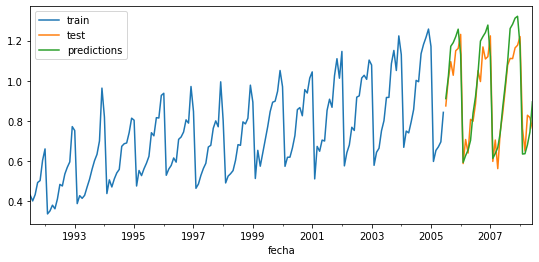

In [22]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [23]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [10, 50],
              'max_depth': [5, 10]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-07-26 22:33:56,654 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:21<00:00,  7.29s/it] 
2021-07-26 22:34:18,544 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.013860
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.014137
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 10}",0.014600
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 10}",0.014618
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 10}",0.040768
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 10}",0.040814
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.042516
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.042600
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.067744
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.068535


In [24]:
forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123)
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10]
Exogenous variable: False
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

2021-07-26 22:34:29,191 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 3
    Number of steps per fold: 36
[0.0328557]


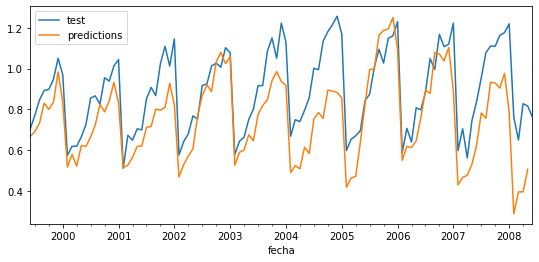

In [25]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
             )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'mean_squared_error',
                            verbose    = True
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=datos_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [26]:
# Feature importance
# ==============================================================================
for step in range(1, forecaster.steps):
    print(f"\n Model step: {step}")
    print(forecaster.get_coef(step = step))


 Model step: 1
[ 0.41027188 -0.14674613  0.09226529 -0.06392558  0.10515625 -0.18531542
  0.07999999 -0.0351197   0.01481861 -0.04322598  0.08527348  0.89015049
 -0.37628168  0.124808   -0.08830264]

 Model step: 2
[ 0.0056728   0.13340405 -0.23853055  0.0135521  -0.09212447  0.01220143
 -0.04157595  0.04695597 -0.06102362  0.06829383  0.9325276  -0.01704699
 -0.00939653 -0.15842891  0.22399086]

 Model step: 3
[ 0.12804067 -0.25166188  0.01728755 -0.05074347 -0.03043504 -0.04790344
  0.04931905 -0.07082373  0.07370185  0.92184399 -0.01634428 -0.00690652
 -0.16008374  0.24659014 -0.01953951]

 Model step: 4
[-0.18221725 -0.00715881 -0.04176313 -0.02903443 -0.03507585  0.0129802
 -0.01335253  0.02212724  0.93878284 -0.02952668  0.01815526 -0.0528953
  0.19973578 -0.0128625   0.00770712]

 Model step: 5
[-9.14330930e-02  2.79653893e-02 -1.77280048e-01  2.06396215e-05
 -3.54220274e-02  9.84134459e-03  1.68818644e-02  9.29791105e-01
 -2.98388681e-02  6.83498787e-03 -5.40478794e-02  2.5675

## Autoreg + 1 exogenous predictor
<br>

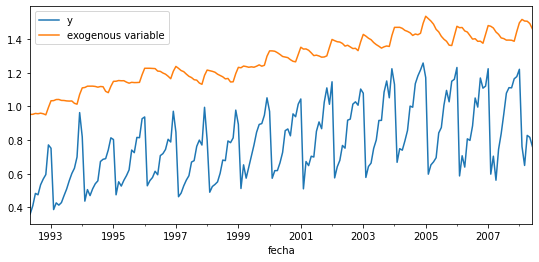

In [27]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

In [37]:
# Understanding creation of predictors from exogen variables
# ==============================================================================
import string
endog = np.arange(10) + 1
exog  = np.array(list(string.ascii_lowercase))[:10]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 3,
                    lags      = 2
                )

X, y = forecaster.create_lags(endog)
print(X)
print(y)

exog_prep = forecaster._preproces_exog(exog)
exog_prep = forecaster._exog_to_multi_output(exog_prep)
print(np.column_stack((X, exog_prep[-X.shape[0]:])))

[[2. 1.]
 [3. 2.]
 [4. 3.]
 [5. 4.]
 [6. 5.]
 [7. 6.]]
[[ 3.  4.  5.]
 [ 4.  5.  6.]
 [ 5.  6.  7.]
 [ 6.  7.  8.]
 [ 7.  8.  9.]
 [ 8.  9. 10.]]
[['2.0' '1.0' 'c' 'd' 'e']
 ['3.0' '2.0' 'd' 'e' 'f']
 ['4.0' '3.0' 'e' 'f' 'g']
 ['5.0' '4.0' 'f' 'g' 'h']
 ['6.0' '5.0' 'g' 'h' 'i']
 ['7.0' '6.0' 'h' 'i' 'j']]


In [38]:
endog = np.arange(10) + 1
exog  = np.column_stack((
            np.array(list(string.ascii_lowercase))[:10],
            np.array(list(string.ascii_uppercase))[:10]
        ))

forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 2,
                    lags      = 3
                )

X, y = forecaster.create_lags(endog)
print(X)
print(y)

exog_prep = forecaster._preproces_exog(exog)
exog_prep = forecaster._exog_to_multi_output(exog_prep)
print(np.column_stack((X, exog_prep[-X.shape[0]:])))

[[3. 2. 1.]
 [4. 3. 2.]
 [5. 4. 3.]
 [6. 5. 4.]
 [7. 6. 5.]
 [8. 7. 6.]]
[[ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]]
[['3.0' '2.0' '1.0' 'd' 'e' 'D' 'E']
 ['4.0' '3.0' '2.0' 'e' 'f' 'E' 'F']
 ['5.0' '4.0' '3.0' 'f' 'g' 'F' 'G']
 ['6.0' '5.0' '4.0' 'g' 'h' 'G' 'H']
 ['7.0' '6.0' '5.0' 'h' 'i' 'H' 'I']
 ['8.0' '7.0' '6.0' 'i' 'j' 'I' 'J']]


In [61]:
def filter_train_X_y_for_step(self, step: int,
                              X_train: np.ndarray,
                              y_train: np.ndarray) -> Tuple[np.array, np.array]:

    '''
    Select columns needed to train a forcaster for a specific step. The imput matrices
    should be created with created with `create_train_X_y()`.         

    Parameters
    ----------
    step : int
        step for which columns must be selected selected. Starts at 0.

    X_train : 2D np.ndarray
        2D array with the training values (predictors).
        
    y_train : 1D np.ndarray
        Values (target) of the time series related to each row of `X_train`.


    Returns 
    -------
    X_train_step : 2D np.ndarray
        2D array with the training values (predictors) for step.
        
    y_train_step : 1D np.ndarray, shape (len(y) - self.max_lag)
        Values (target) of the time series related to each row of `X_train`.

    '''

    if step > self.steps - 1:
        raise Exception(
            f"Invalid value `step`. For this forecaster, the maximum step is {self.steps-1}."
        )

    y_train_step = y_train[:, step]

    if not self.included_exog:
        X_train_step = X_train
    else:
        idx_columns_lags = np.arange(len(self.lags))
        print(idx_columns_lags)
        idx_columns_exog = np.arange(X_train.shape[1])[self.max_lag + step::self.steps]
        idx_columns = np.hstack((idx_columns_lags, idx_columns_exog))
        X_train_step = X_train[:, idx_columns]

    return  X_train_step, y_train_step

In [62]:
# Crear y entrenar forecaster
# ==============================================================================
regressor = Ridge()
forecaster = ForecasterAutoregMultiOutput(
                    regressor = regressor,
                    lags      = [1, 2, 5],
                    steps     = 3
             )

X_train, y_train = forecaster.create_train_X_y(y=np.arange(10), exog= np.arange(100,110))
print(X_train.shape)
print(y_train.shape)
X_train

(3, 6)
(3, 3)


array([[  4.,   3.,   0., 105., 106., 107.],
       [  5.,   4.,   1., 106., 107., 108.],
       [  6.,   5.,   2., 107., 108., 109.]])

In [63]:
X_train_step, y_train_step = forecaster.filter_train_X_y_for_step(X_train=X_train, y_train=y_train, step=0)
print(X_train_step.shape)
print(y_train_step.shape)
X_train_step

(3, 6)
(3,)


array([[  4.,   3.,   0., 105., 106., 107.],
       [  5.,   4.,   1., 106., 107., 108.],
       [  6.,   5.,   2., 107., 108., 109.]])

In [64]:
filter_train_X_y_for_step(forecaster,X_train=X_train, y_train=y_train, step=0)

[0 1 2]


(array([[  4.,   3.,   0., 107.],
        [  5.,   4.,   1., 108.],
        [  6.,   5.,   2., 109.]]),
 array([5., 6., 7.]))

In [52]:
X_train_step, y_train_step = forecaster.filter_train_X_y_for_step(X_train=X_train, y_train=y_train, step=1)
print(X_train_step.shape)
print(y_train_step.shape)
X_train_step

(5, 4)
(5,)


array([[  2.,   1.,   0., 104.],
       [  3.,   2.,   1., 105.],
       [  4.,   3.,   2., 106.],
       [  5.,   4.,   3., 107.],
       [  6.,   5.,   4., 108.]])

In [53]:
X_train_step, y_train_step = forecaster.filter_train_X_y_for_step(X_train=X_train, y_train=y_train, step=2)
print(X_train_step.shape)
print(y_train_step.shape)
X_train_step

(5, 4)
(5,)


array([[  2.,   1.,   0., 105.],
       [  3.,   2.,   1., 106.],
       [  4.,   3.,   2., 107.],
       [  5.,   4.,   3., 108.],
       [  6.,   5.,   4., 109.]])

In [28]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)
forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: Ridge()
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10]
Exogenous variable: True
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

Test error (mse): 0.008071341212160008


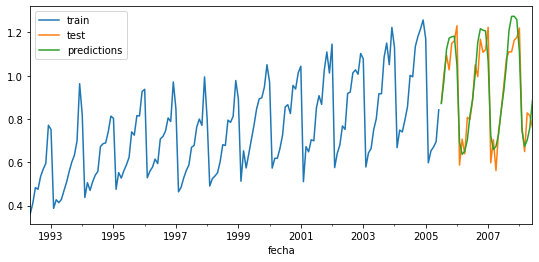

In [29]:
# Predict
# ==============================================================================
predictions = forecaster.predict(
                    exog     = datos_exog_test
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Predict
# ==============================================================================
predictions = forecaster.predict(exog = datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

#0.00807134121216

In [30]:
# Feature importance
# ==============================================================================
for step in range(1, forecaster.steps):
    print(f"\n Model step: {step}")
    print(forecaster.get_coef(step = step))


 Model step: 1
[ 0.39617818  0.06259433  0.0160303  -0.06345751 -0.06637312 -0.05607901
 -0.05524681 -0.01467135  0.05534023  0.1952805   0.21288003]

 Model step: 2
[ 0.16791411  0.04228042 -0.04713965 -0.07098066 -0.07311102 -0.05787811
 -0.05607599  0.03367757  0.06824319  0.39853033  0.26842707]

 Model step: 3
[ 0.03982488 -0.02212498 -0.0386757  -0.03899902 -0.04715761 -0.01872319
 -0.00189792  0.04341716  0.15735046  0.59694355  0.14264852]

 Model step: 4
[-0.02078167 -0.03346347 -0.03166579 -0.03977318 -0.0140786   0.00288662
  0.03420334  0.15061083  0.54612083  0.13033652  0.11271208]

 Model step: 5
[-0.03792479 -0.03517703 -0.04179624 -0.01466614  0.00985731  0.02478454
  0.15347257  0.54299255  0.13905396 -0.03217205  0.11381887]

 Model step: 6
[-0.04580747 -0.04062282 -0.01804242  0.00920478  0.01711427  0.16357021
  0.54609466  0.1448006  -0.02285627 -0.03256472  0.11081872]

 Model step: 7
[-0.05287595 -0.01839052  0.00559173  0.01606558  0.1555033   0.55664096
  0.1

2021-07-26 22:37:14,149 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


[0.041978]


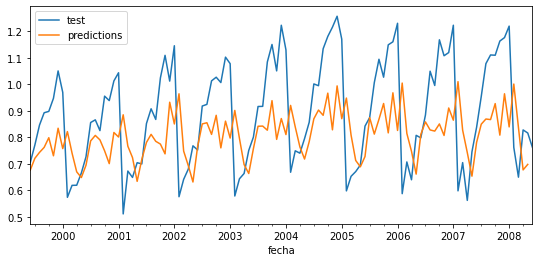

In [31]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 2,
                    lags      = 3
                )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'mean_squared_error'
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=datos_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Autoregressive + n exogenous predictors
<br>

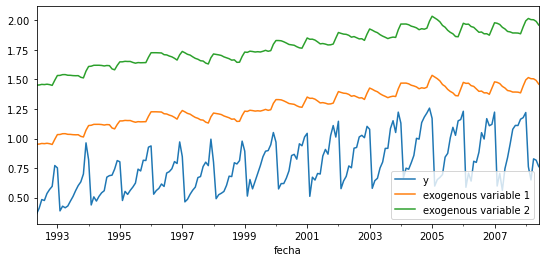

In [32]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

In [33]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)
forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: RandomForestRegressor()
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10]
Exogenous variable: True
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [34]:
# Feature importance
# ==============================================================================
for step in range(1, forecaster.steps):
    print(f"\n Model step: {step}")
    print(forecaster.get_feature_importances(step = step))


 Model step: 1
[0.47841533 0.18454357 0.0915603  0.02466517 0.02829581 0.01772744
 0.03203887 0.01421107 0.02320672 0.05882713 0.02346497 0.02304363]

 Model step: 2
[0.12249537 0.06956998 0.03174266 0.02786652 0.03199213 0.02632588
 0.02852809 0.03767191 0.04417867 0.45288382 0.05792217 0.0688228 ]

 Model step: 3
[0.06413803 0.00932465 0.01780228 0.00487098 0.00445866 0.01211171
 0.01793644 0.05113254 0.02459839 0.78004429 0.0061906  0.00739145]

 Model step: 4
[0.01519207 0.02982648 0.00514492 0.00532361 0.01508141 0.01842369
 0.03905868 0.02723025 0.81874242 0.00855276 0.0095951  0.00782861]

 Model step: 5
[0.02235651 0.00536403 0.00533149 0.01356824 0.02003144 0.0379861
 0.01851844 0.79641461 0.007098   0.0512633  0.01153655 0.01053128]

 Model step: 6
[0.00500907 0.005986   0.0141374  0.01785638 0.0234021  0.02748964
 0.80787467 0.00649558 0.05208934 0.01265127 0.01427765 0.0127309 ]

 Model step: 7
[0.00476667 0.01326415 0.01767567 0.02495769 0.02972096 0.80616529
 0.00766492 

Test error (mse): 0.005161958386317873


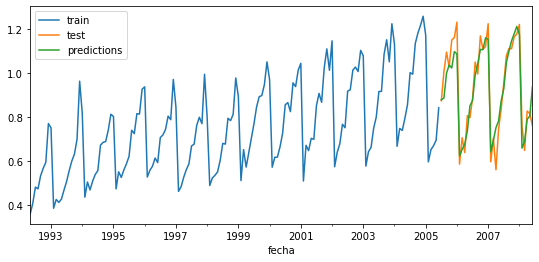

In [35]:
# Predict
# ==============================================================================
predictions = forecaster.predict(
                    steps    = steps,
                    exog     = datos_exog_test
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Predict
# ==============================================================================
predictions = forecaster.predict(exog = datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

2021-07-26 22:37:36,104 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


[0.04520361]


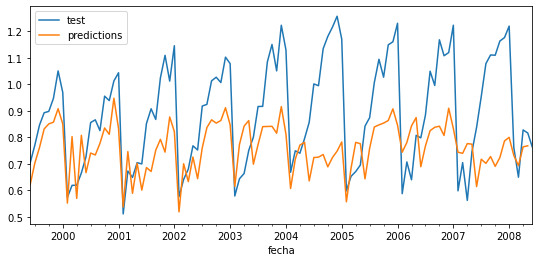

In [36]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'mean_squared_error'
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=datos_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Información de sesión

In [ ]:
from sinfo import sinfo
sinfo()

## Bibliografía
<br>

Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. [libro](https://otexts.com/fpp2/)

Python Data Science Handbook by Jake VanderPlas [libro](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [libro](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

[Markus Löning, Anthony Bagnall, Sajaysurya Ganesh, Viktor Kazakov, Jason Lines, Franz Király (2019): “sktime: A Unified Interface for Machine Learning with Time Series”](http://learningsys.org/neurips19/assets/papers/sktime_ml_systems_neurips2019.pdf)

[Markus Löning, Tony Bagnall, Sajaysurya Ganesh, George Oastler, Jason Lines, ViktorKaz, …, Aadesh Deshmukh (2020). alan-turing-institute/sktime. Zenodo. http://doi.org/10.5281/zenodo.3749000](https://github.com/alan-turing-institute/sktime)

In [ ]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    #font-size: 16px;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    #font-size: 1em;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting series temporales con Python y Scikitlearn by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net
    
</font></p>

<p><strong>¿Te ha gustado el artículo? Tu ayuda es importante</strong></p>

<p style="text-align:left"><font size="3" color="#555">
Mantener un sitio web tiene unos costes elevados, tu contribución me ayudará a seguir generando contenido divulgativo gratuito. ¡Muchísimas gracias!</font>
<form action="https://www.paypal.com/donate" method="post" target="_top">
  <input type="hidden" name="hosted_button_id" value="6NULYFYDKFTQL" />
  <input type="image" src="https://www.paypalobjects.com/en_US/ES/i/btn/btn_donateCC_LG.gif" border="0" name="submit" title="PayPal - The safer, easier way to pay online!" alt="Donate with PayPal button" />
  <img alt="" border="0" src="https://www.paypal.com/en_ES/i/scr/pixel.gif" width="1" height="1" />
  </form>	
</p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.